In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from langdetect import detect, DetectorFactory, LangDetectException
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from tqdm import tqdm


In [8]:
musk_twitter_data = pd.read_csv(os.path.join('Data', 'all_musk_posts.csv'),parse_dates=["createdAt"])

musk_twitter_data["isRetweet"] = musk_twitter_data["isRetweet"].astype(str).str.lower()
musk_twitter_data["possiblySensitive"] = musk_twitter_data["possiblySensitive"].astype(str).str.lower()
musk_twitter_data["fullText"] = musk_twitter_data["fullText"].astype(str)
musk_twitter_data["date"] = musk_twitter_data["createdAt"].dt.date

musk_twitter_data_all = musk_twitter_data.copy()
musk_twitter_data_nlp = musk_twitter_data.copy()

C:\Users\paull\AppData\Local\Temp\ipykernel_32344\1394450992.py:1: DtypeWarning: Columns (11,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  musk_twitter_data = pd.read_csv(os.path.join('Data', 'all_musk_posts.csv'),parse_dates=["createdAt"])


Create NLP-Dataframe for sentiment/emotion analysis. The dataframe should contain only:
- original posts by Elon Musk (no retweets)
- Only English posts
- not empty posts

In [9]:
def safe_detect(text):
    try:
        text = str(text).strip()
        if len(text) < 10:
            return "unknown"
        return detect(text)
    except LangDetectException:
        return "unknown"

musk_twitter_data_nlp = musk_twitter_data_nlp[musk_twitter_data_nlp["isRetweet"] != "true"]
musk_twitter_data_nlp = musk_twitter_data_nlp[musk_twitter_data_nlp["fullText"].str.strip() != ""]
musk_twitter_data_nlp["language"] = musk_twitter_data_nlp["fullText"].progress_apply(safe_detect)
musk_twitter_data_nlp = musk_twitter_data_nlp[musk_twitter_data_nlp["language"] == "en"]

100%|██████████| 54007/54007 [09:51<00:00, 91.30it/s] 


In [10]:
print("musk_twitter_data_all:", musk_twitter_data_all.shape)
print("musk_twitter_data_nlp:", musk_twitter_data_nlp.shape)

musk_twitter_data_all: (55099, 25)
musk_twitter_data_nlp: (42795, 26)


Dataframe mit allen Tagen erstellen und die Anzahl der Tweets ergänzen.

         date  tweet_count
0  2010-06-04            1
1  2010-06-05            0
2  2010-06-06            0
3  2010-06-07            0
4  2010-06-08            0


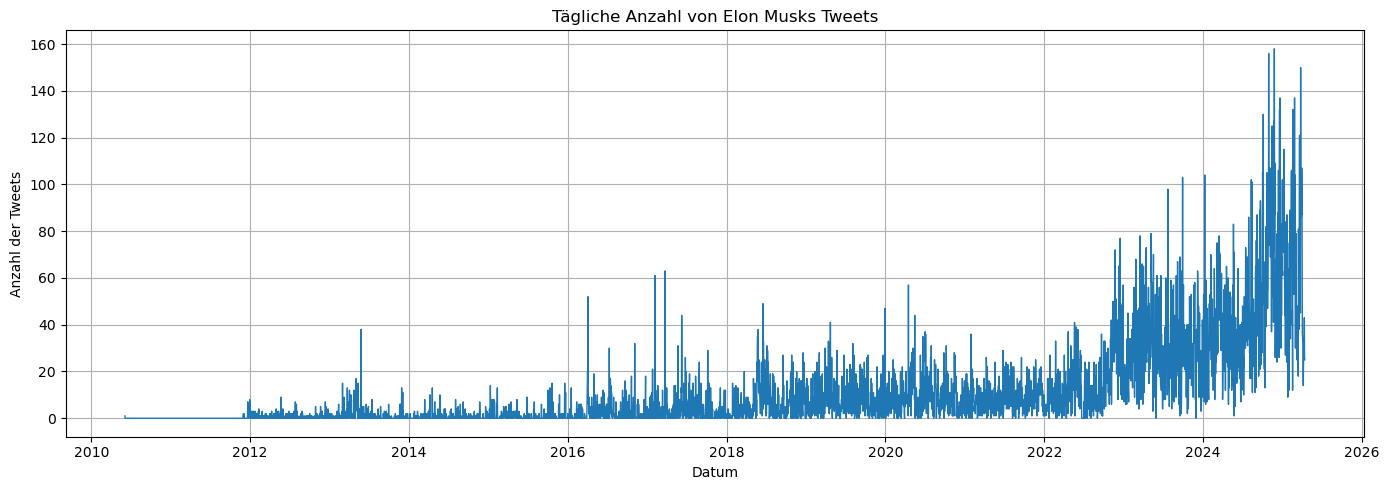

In [13]:
# Angenommen musk_twitter_data_all existiert bereits (aus Schritt vorher)
musk_twitter_data_all["date"] = pd.to_datetime(musk_twitter_data_all["createdAt"]).dt.date

# Anzahl der Tweets pro Tag zählen
tweet_counts = (
    musk_twitter_data_all
    .groupby("date")
    .size()
    .reset_index(name="tweet_count")
)

# Alle Tage im betrachteten Zeitraum erzeugen
all_dates = pd.DataFrame(pd.date_range(musk_twitter_data_all["date"].min(), musk_twitter_data_all["date"].max()), columns=["date"])
all_dates["date"] = all_dates["date"].dt.date

# Mergen mit vollständigem Datum, fehlende Tage mit 0 auffüllen
tweet_counts_complete = all_dates.merge(tweet_counts, on="date", how="left").fillna(0)
tweet_counts_complete["tweet_count"] = tweet_counts_complete["tweet_count"].astype(int)

# Vorschau
print(tweet_counts_complete.head())

plt.figure(figsize=(14, 5))
plt.plot(tweet_counts_complete["date"], tweet_counts_complete["tweet_count"], linewidth=1)
plt.title("Tägliche Anzahl von Elon Musks Tweets")
plt.xlabel("Datum")
plt.ylabel("Anzahl der Tweets")
plt.grid(True)
plt.tight_layout()
plt.show()

Sentiment Analysis

100%|██████████| 42795/42795 [57:45<00:00, 12.35it/s]  
C:\Users\paull\AppData\Local\Temp\ipykernel_32344\2226095495.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=musk_twitter_data_nlp, x="sentiment", palette="Set2")
C:\Users\paull\AppData\Local\Temp\ipykernel_32344\2226095495.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=musk_twitter_data_nlp, x="sentiment_polarity", palette="Set2")


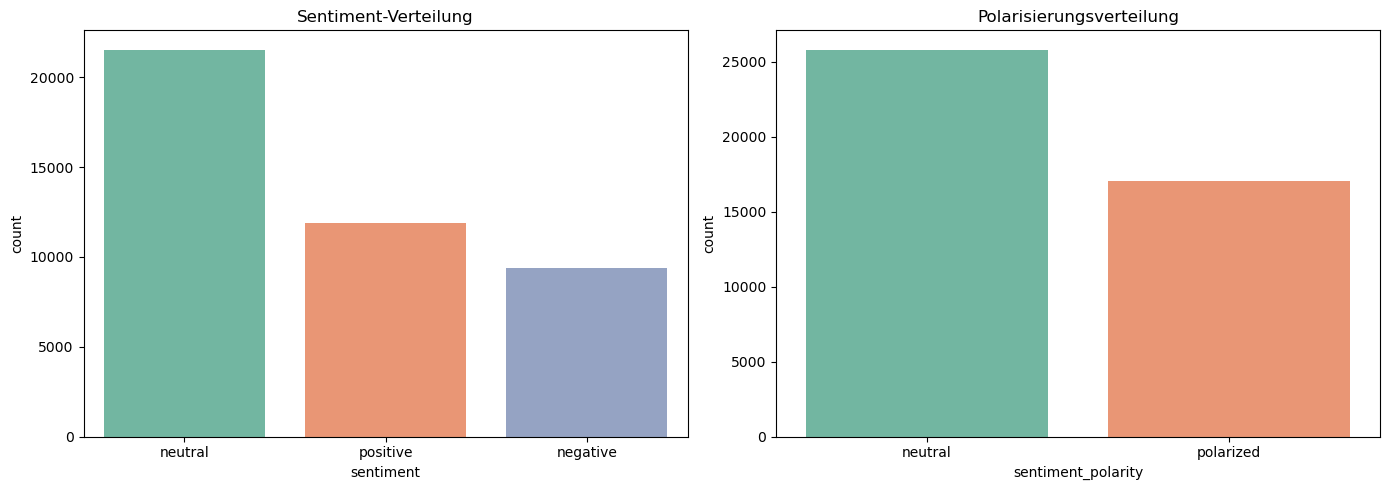

In [17]:
# 1. NLP-Datenframe reduzieren
musk_twitter_data_nlp = musk_twitter_data_nlp[["date", "fullText", "createdAt", "possiblySensitive"]].copy()

# 2. Modell und Tokenizer laden
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 3. Text-Vorverarbeitung
def preprocess(text):
    return text.replace("\n", " ").strip()

# 4. Sentiment + Wahrscheinlichkeiten
def get_sentiment_probs(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = model(**encoded_input)
    probs = softmax(output.logits.numpy()[0])
    return {
        "sentiment": ['negative', 'neutral', 'positive'][probs.argmax()],
        "neg": probs[0],
        "neu": probs[1],
        "pos": probs[2],
    }

# 5. Sentiment-Spalten erzeugen
tqdm.pandas()
results = musk_twitter_data_nlp["fullText"].progress_apply(get_sentiment_probs).apply(pd.Series)
musk_twitter_data_nlp = pd.concat([musk_twitter_data_nlp, results], axis=1)

# 6. Polarisierungslabel hinzufügen
def polarized_label(row):
    if max(row["pos"], row["neg"]) > 0.6:
        return "polarized"
    return "neutral"

musk_twitter_data_nlp["sentiment_polarity"] = musk_twitter_data_nlp.apply(polarized_label, axis=1)

# 7. Sentiment- und Polarisierungsverteilung anzeigen
plt.figure(figsize=(14, 5)) 

plt.subplot(1, 2, 1)
sns.countplot(data=musk_twitter_data_nlp, x="sentiment", palette="Set2")
plt.title("Sentiment-Verteilung")

plt.subplot(1, 2, 2)
sns.countplot(data=musk_twitter_data_nlp, x="sentiment_polarity", palette="Set2")
plt.title("Polarisierungsverteilung")

plt.tight_layout()
plt.show()


Aggregation auf Tage

In [18]:
# 8. Vollständige Datumsliste aus tweet_counts_complete verwenden
all_dates = tweet_counts_complete[["date"]].copy()

# 9. Sentiment-Wahrscheinlichkeiten aggregieren
sentiment_avg = (
    musk_twitter_data_nlp
    .groupby("date")[["neg", "neu", "pos"]]
    .mean()
    .reset_index()
)

# 10. NLP-Tweetanzahl pro Tag
nlp_counts = (
    musk_twitter_data_nlp
    .groupby("date")
    .size()
    .reset_index(name="nlp_tweet_count")
)

# 11. Polaritätsanteile
polarization = (
    musk_twitter_data_nlp
    .groupby("date")["sentiment_polarity"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    .reset_index()
    .rename(columns={"neutral": "share_neutral", "polarized": "share_polarized"})
)

# 12. Mergen aller NLP-Komponenten auf Basis der vorhandenen Datumsstruktur
sentiment_daily = all_dates.copy()
sentiment_daily = sentiment_daily.merge(sentiment_avg, on="date", how="left")
sentiment_daily = sentiment_daily.merge(nlp_counts, on="date", how="left")
sentiment_daily = sentiment_daily.merge(polarization, on="date", how="left")

# Fehlende Werte mit 0 füllen
sentiment_daily[["neg", "neu", "pos", "share_neutral", "share_polarized"]] = sentiment_daily[
    ["neg", "neu", "pos", "share_neutral", "share_polarized"]
].fillna(0)
sentiment_daily["nlp_tweet_count"] = sentiment_daily["nlp_tweet_count"].fillna(0).astype(int)

# 13. Finaler Merge mit Tweet-Zähler-DataFrame
final_daily_df = tweet_counts_complete.merge(sentiment_daily, on="date", how="left")

In [35]:
final_daily_df.tail(10)

,date,tweet_count,neg,neu,pos,nlp_tweet_count,share_neutral,share_polarized
5418,2025-04-04,32,0.255393,0.465695,0.278913,9,0.555556,0.444444
5419,2025-04-05,24,0.125652,0.698284,0.176064,3,1.000000,0.000000
5420,2025-04-06,14,0.732826,0.252824,0.014350,4,0.250000,0.750000
5421,2025-04-07,22,0.049054,0.617142,0.333804,4,0.750000,0.250000
5422,2025-04-08,30,0.305568,0.472978,0.221454,4,0.500000,0.500000
5423,2025-04-09,26,0.004000,0.143726,0.852275,2,0.000000,1.000000
5424,2025-04-10,26,0.291096,0.516404,0.192500,6,0.666667,0.333333
5425,2025-04-11,43,0.254146,0.389997,0.355857,8,0.500000,0.500000
5426,2025-04-12,26,0.855882,0.122257,0.021860,2,0.000000,1.000000
5427,2025-04-13,25,0.015318,0.790380,0.194303,3,1.000000,0.000000


Visualize:
- Tweet activity over time
- Sentiment development over time
- Polarisation percentage over time

In [29]:
fig1 = px.line(
    final_daily_df,
    x="date",
    y=["tweet_count", "nlp_tweet_count"],
    labels={"value": "Tweetanzahl", "variable": "Typ"},
    title="Elon Musks Tweet-Aktivität über Zeit (interaktiv)"
)

fig2 = px.line(
    final_daily_df,
    x="date",
    y=["pos", "neu", "neg"],
    labels={"value": "Sentiment-Wahrscheinlichkeit", "variable": "Sentiment"},
    title="Durchschnittliches Sentiment pro Tag (interaktiv)"
)

fig3 = px.line(
    final_daily_df,
    x="date",
    y=["share_polarized", "share_neutral"],
    labels={"value": "Anteil", "variable": "Kategorie"},
    title="Anteil polarisiert vs. neutral pro Tag (interaktiv)"
)

fig1.show()
fig2.show()
fig3.show()

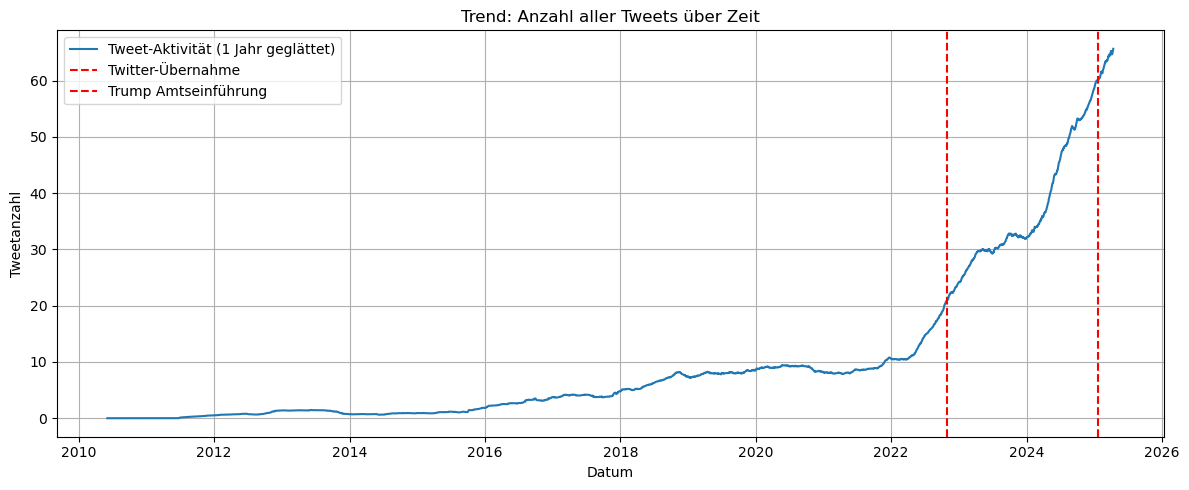

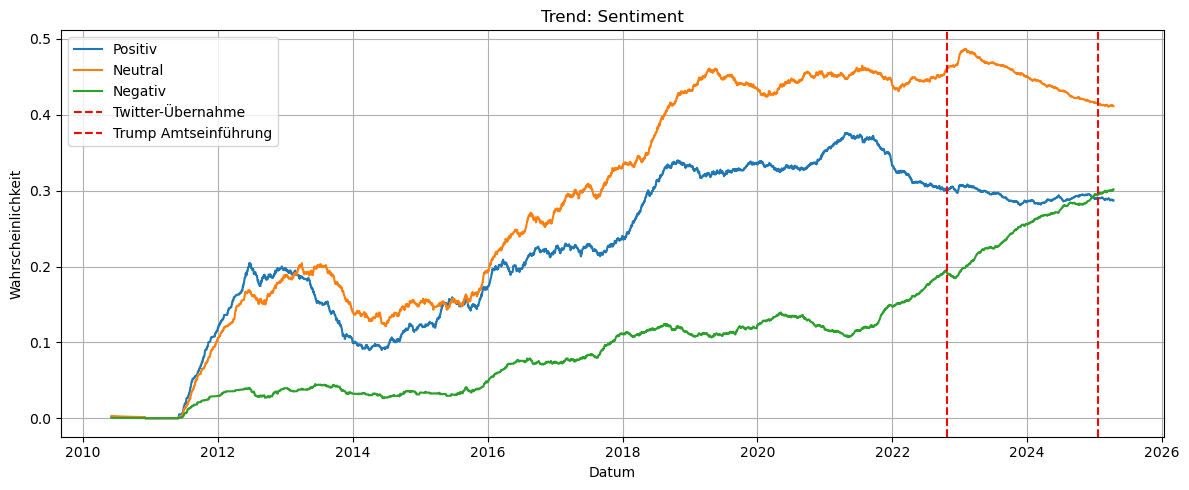

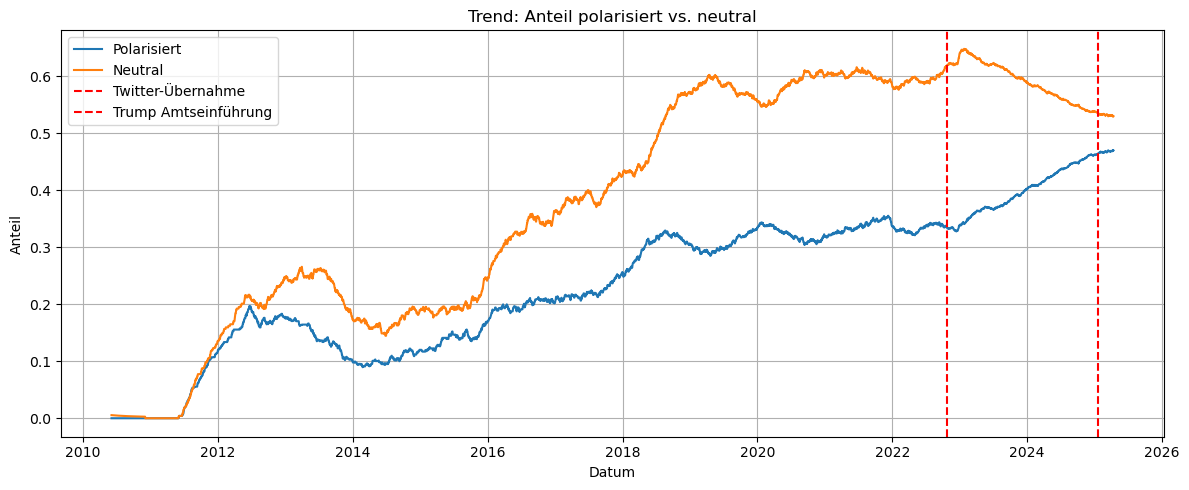

In [36]:
final_daily_df["date"] = pd.to_datetime(final_daily_df["date"])
trend_df = final_daily_df.copy()

# Rolling-Averages (1 Jahr Glättung)
trend_df["tweet_trend"] = trend_df["tweet_count"].rolling(window=365, center=True, min_periods=1).mean()
trend_df["pos_trend"] = trend_df["pos"].rolling(window=365, center=True, min_periods=1).mean()
trend_df["neu_trend"] = trend_df["neu"].rolling(window=365, center=True, min_periods=1).mean()
trend_df["neg_trend"] = trend_df["neg"].rolling(window=365, center=True, min_periods=1).mean()
trend_df["polarized_trend"] = trend_df["share_polarized"].rolling(window=365, center=True, min_periods=1).mean()
trend_df["neutral_trend"] = trend_df["share_neutral"].rolling(window=365, center=True, min_periods=1).mean()

plt.figure(figsize=(12, 5))
plt.plot(trend_df["date"], trend_df["tweet_trend"], label="Tweet-Aktivität (1 Jahr geglättet)")
plt.axvline(pd.to_datetime("2022-10-27"), color="red", linestyle="--", label="Twitter-Übernahme")
plt.axvline(pd.to_datetime("2025-01-20"), color="red", linestyle="--", label="Trump Amtseinführung")
plt.title("Trend: Anzahl aller Tweets über Zeit")
plt.xlabel("Datum")
plt.ylabel("Tweetanzahl")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(trend_df["date"], trend_df["pos_trend"], label="Positiv")
plt.plot(trend_df["date"], trend_df["neu_trend"], label="Neutral")
plt.plot(trend_df["date"], trend_df["neg_trend"], label="Negativ")
plt.axvline(pd.to_datetime("2022-10-27"), color="red", linestyle="--", label="Twitter-Übernahme")
plt.axvline(pd.to_datetime("2025-01-20"), color="red", linestyle="--", label="Trump Amtseinführung")
plt.title("Trend: Sentiment")
plt.xlabel("Datum")
plt.ylabel("Wahrscheinlichkeit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(trend_df["date"], trend_df["polarized_trend"], label="Polarisiert")
plt.plot(trend_df["date"], trend_df["neutral_trend"], label="Neutral")
plt.axvline(pd.to_datetime("2022-10-27"), color="red", linestyle="--", label="Twitter-Übernahme")
plt.axvline(pd.to_datetime("2025-01-20"), color="red", linestyle="--", label="Trump Amtseinführung")
plt.title("Trend: Anteil polarisiert vs. neutral")
plt.xlabel("Datum")
plt.ylabel("Anteil")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Observations:
- Exponential higher activities since a few months befor twitter aquisition
- Change in sentiment from positive to negative after Trums inauguration
- Trend to more polarization after Twitter aquisition